In [1]:
import pandas as pd
import numpy as np
from sklearn import pipeline, preprocessing, model_selection, base, compose, metrics
import torch
import torch.nn as nn
import torch.optim as optim
import skorch
import os
import joblib

import matplotlib.pyplot as plt

%matplotlib inline

from utils import ReorderTransformer, DTypeTransformer, LabelingTransformer, RestoreMoveCheckpoint, DimensionTransformer, TransformerModelv4, build_inference_pipe, get_num_parameters

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
MODEL_DIRS = ['models/nn', 'models/transformer_v3', 'models/transformer_v4']

# Load history

In [3]:
models_info = {}

for model_dir in MODEL_DIRS:
    
    models_info[model_dir] = {}
    
    checkpoints = []
    model_type = None
    
    for file in os.listdir(model_dir):
        if os.path.isdir(os.path.join(model_dir, file)):
            checkpoints.append(os.path.join(model_dir, file))
        else:
            model_type = joblib.load(os.path.join(model_dir, file))
    
    
    for checkpoint in checkpoints:
        model_params = joblib.load(os.path.join(checkpoint, 'model_params.jl'))
        model_type['classifier'].set_params(**model_params)
        model_type['classifier'].load_params(
            f_params=os.path.join(checkpoint, 'params.pt'), 
            f_optimizer=os.path.join(checkpoint, 'optimizer.pt'), 
            f_criterion=os.path.join(checkpoint, 'criterion.pt'), 
            f_history=os.path.join(checkpoint, 'history.json')
            ) 
        
        for epoch in reversed(range(len(model_type['classifier'].history))):
            if model_type['classifier'].history[epoch]['valid_acc_best']:
                model_acc = model_type['classifier'].history[epoch]['valid_acc']
                model_epochs = epoch
                break
        
        models_info[model_dir][checkpoint] = {
            'n_params': get_num_parameters(model_type['classifier'].module_),
            'acc': model_acc,
            'epoch': model_epochs            
        }

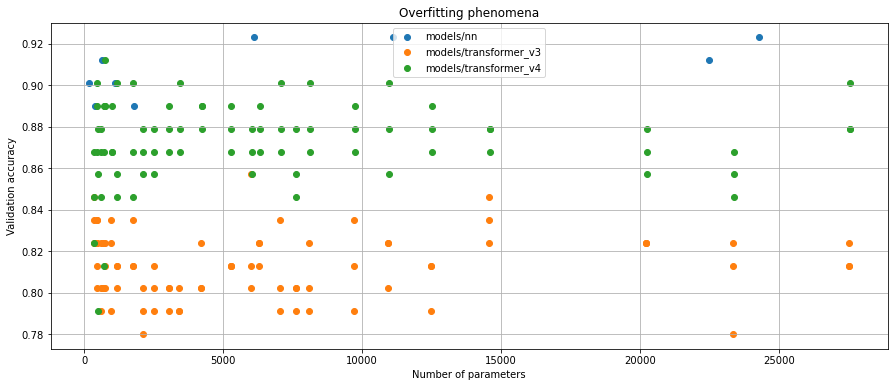

In [4]:
# Data for plotting
fig, ax = plt.subplots(figsize=(15, 6))

for info_key in models_info:
    params = []
    acc = []
    epochs = []
    for chkpt_key in models_info[info_key]:
        params.append(models_info[info_key][chkpt_key]['n_params'])
        acc.append(models_info[info_key][chkpt_key]['acc'])
        epochs.append(models_info[info_key][chkpt_key]['epoch'])
        
    sort_indices = np.argsort(params) 
    
    params = np.array(params)[sort_indices]
    acc = np.array(acc)[sort_indices]
    epochs = np.array(epochs)[sort_indices]
    

    ax.scatter(params, acc, label=info_key)

ax.set(xlabel='Number of parameters', 
       ylabel='Validation accuracy',
       title='Overfitting phenomena')

ax.grid()
ax.legend()

fig.savefig('Overfitting.png')
plt.show()